In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

In [2]:
train = pd.read_parquet(r'Treat_train_final2.parquet')
test = pd.read_parquet(r'Treat_test_final2.parquet')
y_test= pd.read_csv(r'D:\mock\dataset\y_test.csv')

In [3]:
y_test

tracking_id             datetime  windmill_generated_power(kW/h)
0        WM_19817  17-04-2019 08:53:00                        2.384760
1        WM_18723  30-03-2019 07:43:00                        3.043994
2        WM_34552  10-08-2019 11:33:00                        3.481633
3        WM_28570  26-06-2019 03:53:00                        8.482988
4        WM_36934  27-08-2019 16:43:00                        3.530729
...           ...                  ...                             ...
12081    WM_13376  12-02-2019 11:33:00                        6.339437
12082     WM_1630  12-11-2018 17:33:00                        3.189220
12083    WM_24703  27-05-2019 11:53:00                        5.079966
12084    WM_22893  13-05-2019 21:53:00                        5.969176
12085    WM_14513  20-02-2019 23:43:00                       10.083270

[12086 rows x 3 columns]

In [4]:
#Drop two columns and rename existing to power
y_test = y_test.drop(['tracking_id','datetime'],axis=1)
y_test.columns = ['power']
y_test

power
0       2.384760
1       3.043994
2       3.481633
3       8.482988
4       3.530729
...          ...
12081   6.339437
12082   3.189220
12083   5.079966
12084   5.969176
12085  10.083270

[12086 rows x 1 columns]

In [5]:
#Drop columns not needed for model
x_train=train.drop(['tracking_id','datetime','generated_power'],axis=1)
y_train=train['generated_power']
x_test=test.drop(['tracking_id','datetime'],axis=1)

In [6]:
x_train.head()

wind_speed   atm_temp  shaft_temp  blades_angle  gearbox_temp  engine_temp  \
0   94.820023  16.102410   41.723019      0.903423     82.410573    42.523015   
1  241.832734  27.764785   43.686082      0.495608     44.104919    46.258870   
2   95.484724  16.102410   41.855473     12.652763     42.322098    42.878552   
3  238.819424  16.102410   45.443914     15.115323     44.759643    47.282101   
4   10.722890  16.102410   41.981183      1.715696    -17.616459    43.469852   

   motor_torque  generator_temp        atm_pre  area_temp  ...  \
0   2563.124522       39.468222  103402.961872  26.897875  ...   
1   2372.384119       39.468222   17030.904078  39.801469  ...   
2   1657.169646       39.468222   16125.927107  36.116065  ...   
3   2888.134079       39.468222   18689.732336  46.020045  ...   
4    781.695419       37.423065  114468.169007  34.572941  ...   

   turbine_status_ABC  turbine_status_AC  turbine_status_B  turbine_status_B2  \
0                   0                  0                 0                  0   
1                   0                  0                 0                  0   
2                   1                  0                 0                  0   
3                   1                  0                 0                  0   
4                   0                  0                 0                  0   

   turbine_status_BA  turbine_status_BB  turbine_status_BBB  \
0                  1                  0                   0   
1                  0                  0                   0   
2                  0                  0                   0   
3                  0                  0                   0   
4                  0                  0                   0   

   turbine_status_BCB  turbine_status_BD  turbine_status_D  
0                   0                  0                 0  
1                   0                  0                 0  
2                   0                  0                 0  
3                   0                  0                 0  
4                   0                  0                 0  

[5 rows x 32 columns]

In [7]:
#y_train has stored in array so change it to dataframe
y_train = pd.DataFrame(y_train)
y_train

generated_power
0             6.766521
1             5.966275
2             2.874342
3            14.851089
4             3.519074
...                ...
28195         9.587934
28196         4.522195
28197        11.096599
28198         9.373239
28199         2.860342

[28200 rows x 1 columns]

In [8]:
#Scaling all the data
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train[x_train.columns]), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test[x_test.columns]), columns=x_test.columns)
y_train = pd.DataFrame(scaler.fit_transform(y_train[y_train.columns]), columns=y_train.columns)
y_test = pd.DataFrame(scaler.fit_transform(y_test[y_test.columns]), columns=y_test.columns)


In [9]:
#if you want reverse it to original data
#pd.DataFrame(scaler.inverse_transform(x_test[x_test.columns]), columns=x_test.columns)

In [10]:
x_train

wind_speed  atm_temp  shaft_temp  blades_angle  gearbox_temp  \
0        0.155167  0.409965    0.512765      0.005445      0.576395   
1        0.400316  0.517291    0.520231      0.002987      0.496701   
2        0.156276  0.409965    0.513268      0.076253      0.492992   
3        0.395291  0.409965    0.526918      0.091093      0.498063   
4        0.014932  0.409965    0.513747      0.010340      0.368290   
...           ...       ...         ...           ...           ...   
28195    0.155077  0.478749    0.526748      0.032406      0.402684   
28196    0.154128  0.482960    0.514081      0.002987      0.497076   
28197    0.154067  0.525661    0.525245      0.057556      0.507671   
28198    0.156185  0.506206    0.536764      0.018389      0.574384   
28199    0.069686  0.434065    0.389136      0.015631      0.488706   

       engine_temp  motor_torque  generator_temp   atm_pre  area_temp  ...  \
0         0.498612      0.825250        0.214395  0.081104   0.550176  ...   
1         0.749129      0.748954        0.214395  0.013220   0.756721  ...   
2         0.522453      0.462868        0.214395  0.012508   0.697730  ...   
3         0.817744      0.955254        0.214395  0.014523   0.856260  ...   
4         0.562105      0.112678        0.135738  0.089801   0.673029  ...   
...            ...           ...             ...       ...        ...  ...   
28195     0.901308      0.916640        0.214395  0.015104   0.846803  ...   
28196     0.563317      0.683153        0.214395  0.012878   0.522081  ...   
28197     0.600514      0.920663        0.214395  0.014833   0.842004  ...   
28198     0.652734      0.904259        0.214395  0.014265   0.849599  ...   
28199     0.389909      0.606391        0.214395  0.201437   0.478395  ...   

       turbine_status_ABC  turbine_status_AC  turbine_status_B  \
0                     0.0                0.0               0.0   
1                     0.0                0.0               0.0   
2                     1.0                0.0               0.0   
3                     1.0                0.0               0.0   
4                     0.0                0.0               0.0   
...                   ...                ...               ...   
28195                 0.0                0.0               0.0   
28196                 0.0                0.0               0.0   
28197                 0.0                0.0               0.0   
28198                 0.0                0.0               0.0   
28199                 0.0                0.0               0.0   

       turbine_status_B2  turbine_status_BA  turbine_status_BB  \
0                    0.0                1.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
28195                0.0                0.0                1.0   
28196                0.0                0.0                1.0   
28197                0.0                0.0                0.0   
28198                0.0                0.0                0.0   
28199                0.0                0.0                0.0   

       turbine_status_BBB  turbine_status_BCB  turbine_status_BD  \
0                     0.0                 0.0                0.0   
1                     0.0                 0.0                0.0   
2                     0.0                 0.0                0.0   
3                     0.0                 0.0                0.0   
4                     0.0                 0.0                0.0   
...                   ...                 ...                ...   
28195                 0.0                 0.0                0.0   
28196                 0.0                 0.0                0.0   
28197              

In [11]:
#Model Building
rf_model = RandomForestRegressor()
rf_model.fit(x_train,y_train)

C:\Users\RAGAVI~1\AppData\Local\Temp/ipykernel_15912/370307604.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train,y_train)


RandomForestRegressor()

In [12]:
#Prediciton
y_pred=rf_model.predict(x_test)

In [13]:
y_pred

array([0.65787093, 0.18473922, 0.79147844, ..., 0.25072174, 0.38382782,
       0.45114751])

In [14]:
#Array to DataFrame and rename to pred_power
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['pred_power']
y_pred

pred_power
0        0.657871
1        0.184739
2        0.791478
3        0.363331
4        0.385642
...           ...
12081    0.364862
12082    0.361233
12083    0.250722
12084    0.383828
12085    0.451148

[12086 rows x 1 columns]

In [15]:
y_test

power
0      0.075575
1      0.111902
2      0.136018
3      0.411616
4      0.138723
...         ...
12081  0.293496
12082  0.119904
12083  0.224093
12084  0.273093
12085  0.499799

[12086 rows x 1 columns]

In [16]:
#Create a dataFRame with actual test and predicted value from Random Forest
final= pd.DataFrame()
final['actual']=y_test['power']
final['pred'] = y_pred['pred_power']

In [17]:
final

actual      pred
0      0.075575  0.657871
1      0.111902  0.184739
2      0.136018  0.791478
3      0.411616  0.363331
4      0.138723  0.385642
...         ...       ...
12081  0.293496  0.364862
12082  0.119904  0.361233
12083  0.224093  0.250722
12084  0.273093  0.383828
12085  0.499799  0.451148

[12086 rows x 2 columns]

In [18]:
px.line(final, y=['actual', 'pred'])

In [19]:
px.line(final.head(500), y=['actual', 'pred'])

D:\mock\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

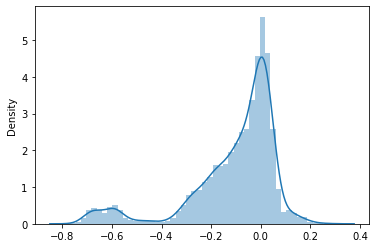

In [20]:
#Plot the errors
sns.distplot(final['actual']-final['pred'])

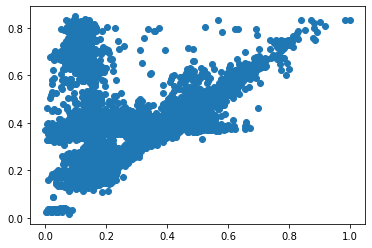

In [21]:
plt.scatter(final['actual'],final['pred'])

In [22]:
#Evaluation Metric
mae= metrics.mean_absolute_error(y_test,y_pred)
print("mae:",mae)
mse = metrics.mean_squared_error(y_test,y_pred)
print("mse:",mse)
rmse = np.sqrt(mse)
print("rmse:",rmse)

mae: 0.13084577978785245
mse: 0.04404346330141985
rmse: 0.20986534564196122


# Random Forest with original data 

In [23]:
x_train1=train.drop(['tracking_id','datetime','generated_power'],axis=1)
y_train1=train['generated_power']
x_test1=test.drop(['tracking_id','datetime'],axis=1)

In [24]:
y_test1= pd.read_csv(r'D:\mock\dataset\y_test.csv')

In [25]:
y_test1

tracking_id             datetime  windmill_generated_power(kW/h)
0        WM_19817  17-04-2019 08:53:00                        2.384760
1        WM_18723  30-03-2019 07:43:00                        3.043994
2        WM_34552  10-08-2019 11:33:00                        3.481633
3        WM_28570  26-06-2019 03:53:00                        8.482988
4        WM_36934  27-08-2019 16:43:00                        3.530729
...           ...                  ...                             ...
12081    WM_13376  12-02-2019 11:33:00                        6.339437
12082     WM_1630  12-11-2018 17:33:00                        3.189220
12083    WM_24703  27-05-2019 11:53:00                        5.079966
12084    WM_22893  13-05-2019 21:53:00                        5.969176
12085    WM_14513  20-02-2019 23:43:00                       10.083270

[12086 rows x 3 columns]

In [26]:
#Drop and rename to power
y_test1 = y_test1.drop(['tracking_id','datetime'],axis=1)
y_test1.columns = ['power1']
y_test1

power1
0       2.384760
1       3.043994
2       3.481633
3       8.482988
4       3.530729
...          ...
12081   6.339437
12082   3.189220
12083   5.079966
12084   5.969176
12085  10.083270

[12086 rows x 1 columns]

In [27]:
#Array to DataFrame
y_train1 = pd.DataFrame(y_train1)
y_train1

generated_power
0             6.766521
1             5.966275
2             2.874342
3            14.851089
4             3.519074
...                ...
28195         9.587934
28196         4.522195
28197        11.096599
28198         9.373239
28199         2.860342

[28200 rows x 1 columns]

In [28]:
#Model Fitting with originalData
rf_model = RandomForestRegressor()
rf_model.fit(x_train1,y_train1)

C:\Users\RAGAVI~1\AppData\Local\Temp/ipykernel_15912/611912852.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor()

In [29]:
y_pred1=rf_model.predict(x_test1)

In [30]:
y_pred1

array([ 4.31097217,  2.51427555,  3.79965607, ...,  5.37275509,
        8.09186657, 10.58615558])

In [31]:
#Array to DataFRame
y_pred1 = pd.DataFrame(y_pred1)

In [32]:
y_pred1.columns = ['pred_power1']
y_pred1

pred_power1
0         4.310972
1         2.514276
2         3.799656
3         7.162225
4         3.332167
...            ...
12081     6.684696
12082     3.315757
12083     5.372755
12084     8.091867
12085    10.586156

[12086 rows x 1 columns]

In [33]:
#Dataframe with original y_test and Predicited y
final1= pd.DataFrame()
final1['actual1']=y_test1['power1']
final1['pred1'] = y_pred1['pred_power1']

In [34]:
final1

actual1      pred1
0       2.384760   4.310972
1       3.043994   2.514276
2       3.481633   3.799656
3       8.482988   7.162225
4       3.530729   3.332167
...          ...        ...
12081   6.339437   6.684696
12082   3.189220   3.315757
12083   5.079966   5.372755
12084   5.969176   8.091867
12085  10.083270  10.586156

[12086 rows x 2 columns]

In [35]:
px.line(final1, y=['actual1', 'pred1'])

In [49]:
px.line(final1.head(100), y=['actual1', 'pred1'])

D:\mock\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

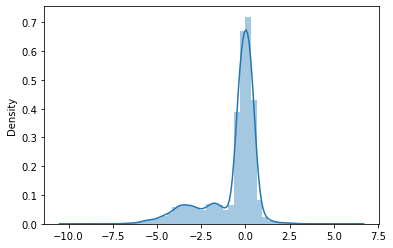

In [37]:
sns.distplot(final1['actual1']-final1['pred1'])

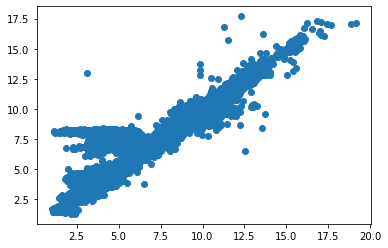

In [38]:
plt.scatter(final1['actual1'],final1['pred1'])

In [39]:
mae1= metrics.mean_absolute_error(y_test1,y_pred1)
print("mae:",mae1)
mse1 = metrics.mean_squared_error(y_test1,y_pred1)
print("mse:",mse1)
rmse1 = np.sqrt(mse1)
print("rmse:",rmse1)

mae: 0.9378680618990161
mse: 2.5622314304669964
rmse: 1.6006971701315014


In [40]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [47]:
import eli5
from eli5.sklearn import PermutationImportance



feature_names = [i for i in x_train1.columns if x_train1[i].dtype in [np.int64]]
perm = PermutationImportance(rf_model, random_state=1).fit(x_test1, y_test1)
eli5.show_weights(perm, feature_names = x_test1.columns.tolist())

In [50]:
perm

PermutationImportance(estimator=RandomForestRegressor(), random_state=1)

In [51]:
from sklearn.metrics import r2_score 
R_square = r2_score(final1['actual1'],final1['pred1']) 

In [52]:
R_square

0.6466602465434577

In [55]:
print('r2 square:',r2_score(final1['actual1'],final1['pred1']))

r2 square: 0.6466602465434577


In [58]:
#Model Building verbose shows wat happens inside
rf_model = RandomForestRegressor(verbose=2)
rf_model.fit(x_train1,y_train1)

C:\Users\RAGAVI~1\AppData\Local\Temp/ipykernel_15912/1232588609.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestRegressor(verbose=2)

In [57]:
y_pred2=rf_model.predict(x_test1)
y_pred2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


array([ 4.48188027,  2.48453889,  3.77340997, ...,  5.43761619,
        8.0127119 , 10.62596842])

In [ ]:
#Array to DataFRame
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = 